In [12]:
"""
Solution notebook for visualization large images.
"""

from localtileserver import TileClient, get_leaflet_tile_layer
from niceview.utils.raster import geo_ref_raster
from scipy.sparse import load_npz
import json
import geojsoncontour
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import rasterio

In [2]:
DATA_PATH = './data/'
PLOT_PATH = './plots/'

In [3]:
####################################################################################################
# Part - georefence image

georef_img_path = geo_ref_raster(DATA_PATH, 'raster.tiff')

Georeferenced image already exists.


In [4]:
####################################################################################################
# Part - read georeferenced image

geo_ref_img = rasterio.open(georef_img_path)
lon, lat = geo_ref_img.xy(5000, 5000)
lon_min, lat_min, lon_max, lat_max = geo_ref_img.bounds
num_digits = len(str(lon)) - len(str(int(lon))) - 1
print(f'lon min: {lon_min}, lon max: {lon_max}')
print(f'lat min: {lat_min}, lat max: {lat_max}')
print(f'number of digits after decimal point: {num_digits}')

# make meshgrid
xs = np.linspace(lon_min, lon_max, geo_ref_img.width, dtype=np.float64)
ys = np.linspace(lat_min, lat_max, geo_ref_img.height, dtype=np.float64)
xx, yy = np.meshgrid(xs, ys)
y_max, x_max = xx.shape
print(f'y max: {y_max}, x max: {x_max}')

lon min: 4.511250882884077, lon max: 4.600325040739397
lat min: -0.0877032274877575, lat max: 0.0
number of digits after decimal point: 16
y max: 9660, x max: 9811


In [5]:
####################################################################################################
# Part - mask data processing

mask = load_npz(DATA_PATH + 'raster.npz')
mask = mask.toarray()
mask_y_max, mask_x_max = mask.shape
print(f'mask y max: {mask_y_max}, mask x max: {mask_x_max}')

# crop mask to make it the same size as the image
num_zero_rows = y_max - mask_y_max
zeros_rows = np.zeros((num_zero_rows, x_max), dtype=mask.dtype)
crop = mask[:y_max, :x_max]
crop = np.vstack((crop, zeros_rows))
assert crop.shape == xx.shape

mask y max: 9626, mask x max: 9843


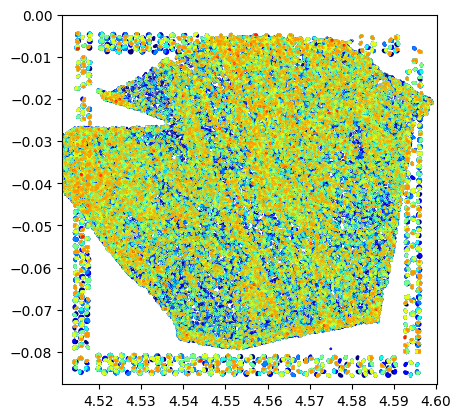

In [6]:
####################################################################################################
# Part - contour to geojson

fig, ax = plt.subplots()
contour = ax.contour(xx, yy, crop, cmap=plt.cm.jet)
ax.set_aspect('equal')

In [76]:
####################################################################################################
# Part - plot image

map_client = TileClient(geo_ref_img, cors_all=True)
map_tile_layer = get_leaflet_tile_layer(map_client)

fig = go.Figure(
    data=(
        go.Scattermapbox(
            lon=[lon],
            lat=[lat],
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=10,
            ),
            text='center',
            hoverinfo='lat+lon+text',
        ),
        go.Scattermapbox(
            lon=[lon_min, lon_min, lon_max, lon_max, lon_min],
            lat=[lat_min, lat_max, lat_max, lat_min, lat_min],
            mode='lines',
            line=go.scattermapbox.Line(
                width=1,
            ),
            text='bounds',
            hoverinfo='text',
        ),
    ),
    layout=go.Layout(
        mapbox=dict(
            style='white-bg',
            center=dict(lon=map_client.center()[1], lat=map_client.center()[0]),
            zoom=map_client.default_zoom,
            pitch=0,
            layers=[
                dict(
                    below='traces',
                    sourcetype='raster',
                    source=[map_tile_layer.url],
                ),
            ],
        ),
        margin=dict(l=30, r=30, t=30, b=30),
        autosize=False,
        width=700,
        height=700,
        paper_bgcolor='LightSteelBlue',
    ),
)
fig.show()

In [1]:
print(1)

1
